In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import os 
from pprint import pprint

import cv2
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [2]:
def display_image(image, figsize=(15,10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.imshow(image)

In [3]:
image = cv2.imread('Images/grid_table01.png', cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(image, (17,17), cv2.BORDER_CONSTANT)

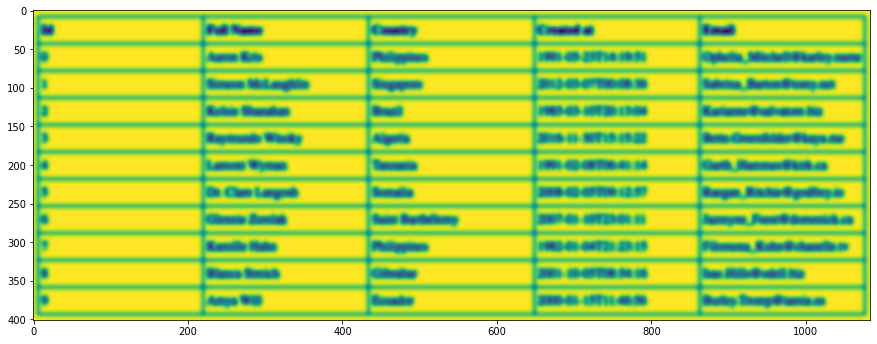

In [4]:
display_image(blurred)

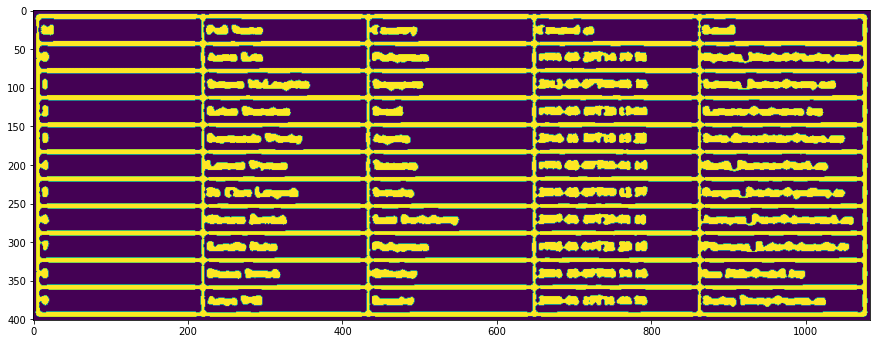

In [5]:
threshold_image = cv2.adaptiveThreshold(~blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)
display_image(threshold_image)

### Get the contours from the image

In [6]:
vertical = horizontal = threshold_image.copy()
SCALE = 5

image_width, image_height = horizontal.shape
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
horizontally_opened = cv2.morphologyEx(threshold_image, cv2.MORPH_OPEN, horizontal_kernel)
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
vertically_opened = cv2.morphologyEx(threshold_image, cv2.MORPH_OPEN, vertical_kernel)

horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))

mask = horizontally_dilated + vertically_dilated
contours, heirarchy = cv2.findContours(
    mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#### Extracting Tables

In [7]:
image.shape

(401, 1084)

In [8]:
MIN_TABLE_AREA = 1e5
table_contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
perimeter_lengths = [cv2.arcLength(c, True) for c in table_contours]
epsilons = [0.1 * p for p in perimeter_lengths]
approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(table_contours, epsilons)]

# approx_rects = [p for p in approx_polys if len(p) == 4]
bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

# The link where a lot of this code was borrowed from recommends an
# additional step to check the number of "joints" inside this bounding rectangle.
# A table should have a lot of intersections. We might have a rectangular image
# here though which would only have 4 intersections, 1 at each corner.
# Leaving that step as a future TODO if it is ever necessary.
tables = [image[y:y+h, x:x+w] for x, y, w, h in bounding_rects]

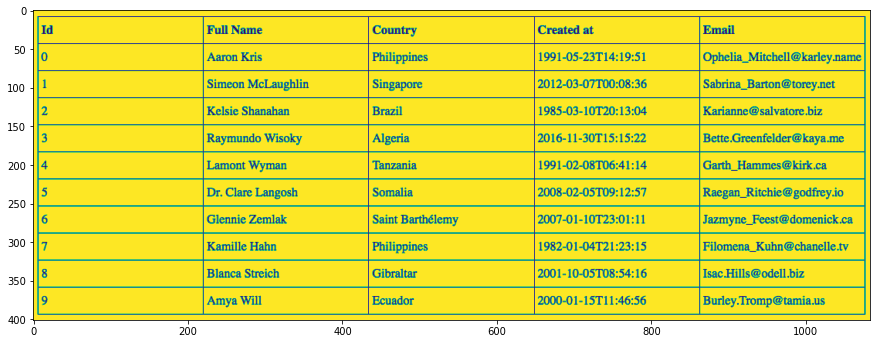

In [9]:
display_image((tables[0]))

### Identifing cells in the table

In [10]:
vertical = horizontal = threshold_image.copy()
SCALE = 5

image_width, image_height = horizontal.shape
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
horizontally_opened = cv2.morphologyEx(threshold_image, cv2.MORPH_OPEN, horizontal_kernel)
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
vertically_opened = cv2.morphologyEx(threshold_image, cv2.MORPH_OPEN, vertical_kernel)

horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))

mask = horizontally_dilated + vertically_dilated
contours, heirarchy = cv2.findContours(
    mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [11]:

perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
epsilons = [0.05 * p for p in perimeter_lengths]
approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]

# Filter out contours that aren't rectangular. Those that aren't rectangular
# are probably noise.
approx_rects = [p for p in approx_polys if len(p) == 4]
bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

In [12]:
len(bounding_rects)

62

In [13]:
# Filter out rectangles that are too narrow or too short.
MIN_RECT_WIDTH = 40
MIN_RECT_HEIGHT = 10
bounding_rects = [
    r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
]

len(bounding_rects)

56

In [14]:
# The largest bounding rectangle is assumed to be the entire table.
# Remove it from the list. We don't want to accidentally try to OCR the entire table.

largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
bounding_rects = [b for b in bounding_rects if b is not largest_rect]
len(bounding_rects)

55

In [15]:
cells = [c for c in bounding_rects]

In [17]:
def cell_in_same_row(c1, c2):
    c1_center = c1[1] + c1[3] - c1[3] / 2
    c2_bottom = c2[1] + c2[3]
    c2_top = c2[1]
    return c2_top < c1_center < c2_bottom

orig_cells = [c for c in cells]
rows = []
while cells:
    first = cells[0]
    rest = cells[1:]
    cells_in_same_row = sorted([c for c in rest if cell_in_same_row(c, first)],
                               key=lambda c: c[0])

    row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
    rows.append(row_cells)
    cells = [
        c for c in rest
        if not cell_in_same_row(c, first)
    ]

In [18]:
        details = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
        details_df = pd.DataFrame(details)
        details_df['right'] = details_df.left + details_df.width
        details_df['bottom'] = details_df.top + details_df.height
        details_df.head()
        df = details_df

In [19]:
def avg_height_of_center(row):
    centers = [y + h - h / 2 for x, y, w, h in row]
    return sum(centers) / len(centers)

rows.sort(key=avg_height_of_center)


cell_images_rows = []
table_data = {}
for ind, row in enumerate(rows):
    cell_images_row = []
    cols = {}
    for i, (x, y, w, h) in enumerate(row):
        tmp_df = df[(df.left>=x) & (df.right<=x+w) & (df.top>=y) & (df.bottom<=y+h)]
        text = ' '.join([i.strip() for i in tmp_df.text.values if i.strip() != ''])
        cols[i] = text
        cell_images_row.append(image[y:y+h, x:x+w])
    table_data[ind] = cols
    cell_images_rows.append(cell_images_row)
table = pd.DataFrame.from_dict(table_data).T
table

,0,1,2,3,4
0,Ia,Full Name,,Created at,Email
1,,Aaron Kris,,1991-05-23714:19:51,Ophelia_Mitchell@karley.name
2,1,Simeon McLaughlin,Singapore,2012-03-07T00:08:36,Sabrina_Barton@torey.net
3,2,Kelsie Shanahan,Brazil,1985-03-10T2,Karianne@salvatore biz
4,3,Raymundo Wisoky,Algeria,2016-11-30T15:,Bette.Greenfelder@kaya.me
5,4,Lamont Wyman,Tanzania,1991-02-08T06:,Garth_Hammes@kirk.ca
6,5,Dr. Clare Langosh,,2008-02-05T09:,Raegan_Ritchie@ godfrey.io
7,6,Glennie Zemlak,Saint Barthélemy,2007-01-10723:,Jazmyne_Feest@domenick.ca
8,7,Kamille Hahn,,1982-01-04T2,Filomena_Kuhn@chanelle.v
9,8,Blanca Streich,,2001-10-05T08:,Isac Hills@odell


In [20]:
len(cell_images_rows), len(cell_images_rows[1])

(11, 5)

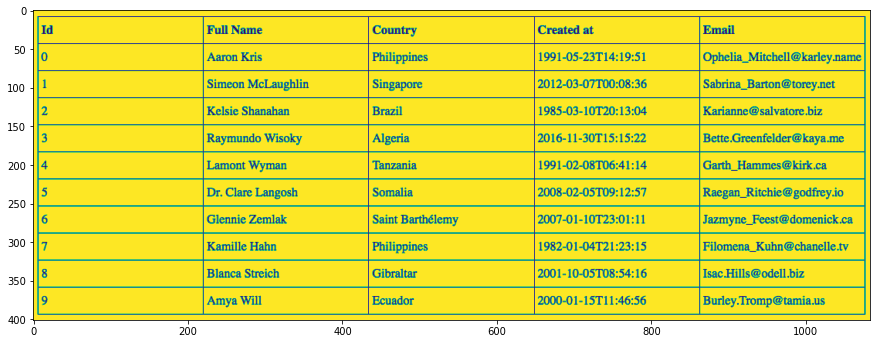

In [21]:
display_image(image)

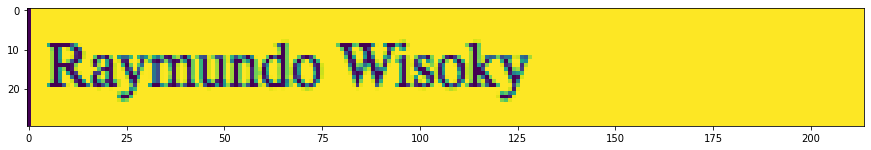

In [22]:
display_image(cell_images_rows[4][1])

In [23]:
pytesseract.image_to_string(cell_images_rows[4][1])

'Raymundo Wisoky\n\x0c'

In [24]:
custom_config = r'--oem 1 --psm 13 '

for row in cell_images_rows:
    cols = []
    for col in row:
        text = pytesseract.image_to_string(col, config=custom_config).strip()
        cols.append(text)
    print(cols)

['Wo', 'FulName', 'Country', 'Createdat', 'Email']
['OO', 'Aaron Kris', 'Philippines', '1991-05-23T14:19:51', '|Ophelia_Mitchell@karley.name']
['Po', 'Simeon McLaughlin', 'Singapore', '2012-03-07T00:08:36', 'Sabrina_Barton@torey.net']
['2', 'Kelsie Shanahan', 'Brazil', '1985-03-10T20:13:04', 'Karianne@salvatore.biz']
['Bo', 'Raymundo Wisoky', 'Algeria', '2016-11-30T15:15:22', '/Bette.Greenfelder@kayame']
['4', 'Lamont Wyman', 'Tanzania', '1991-02-08T06:41:14', '|Garth_Hammes@kirkca']
['So', 'Dr.Clare Langosh', 'Somalia', '2008-02-05T09:12:57', 'Raegan_Ritchie@godfrey.io']
['6', 'Glennie Zemlak', 'Saint Barthélemy', '2007-01-10T23:01:11', '|Jazmyne_Feest@domenick.ca_']
['To', 'KamilleHahn', 'Philippines', '1982-01-04721:23:15', 'Filomena_Kuhn@chanelle.tv']
['Bo', 'Blanca Stich =', 'Gibraltar', '2001-10-05T08:54:16', 'IsacHills@odellbiz']
['9', 'AmyaWil', 'Eouador', '2000-01-15T11:46:56', 'BurleyTromp@tamiaus']
